# Imports

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rd
import cv2
import os
from importlib import reload
from glob import glob
import aligner as temp_a
from aligner import Aligner

reload(temp_a)


<module 'aligner' from 'd:\\OneDrive - Instituto Superior de Engenharia de Lisboa\\Mestrado\\Semestre 2\\VARM\\P1\\Face-Detection-Recognition-main\\aligner.py'>

# Normalize Input Images:

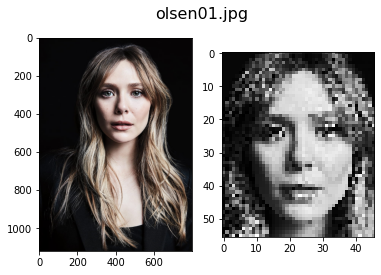

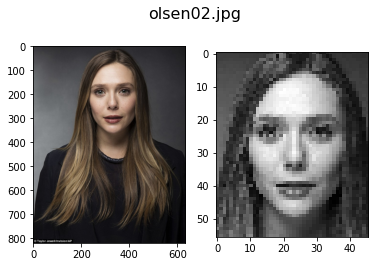

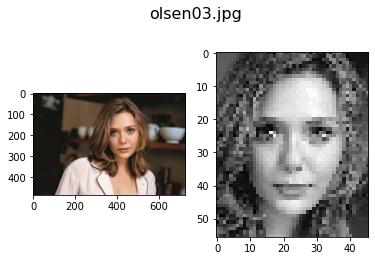

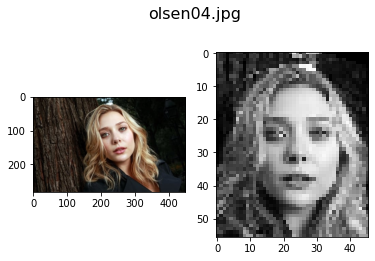

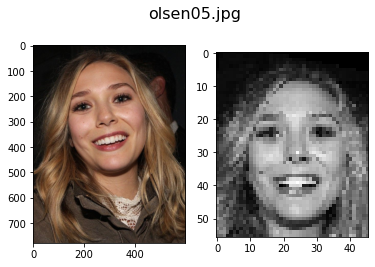

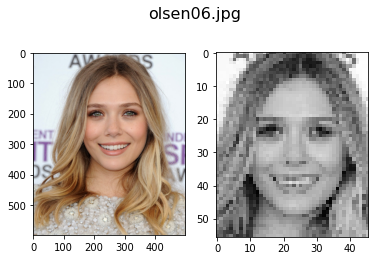

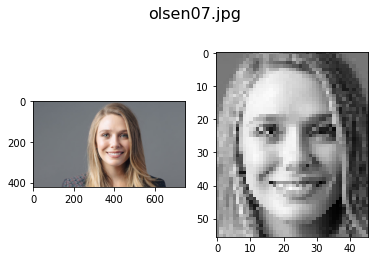

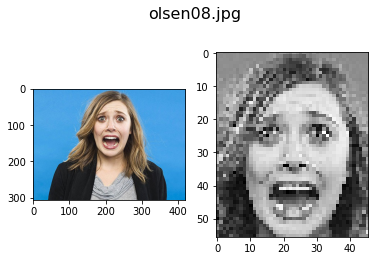

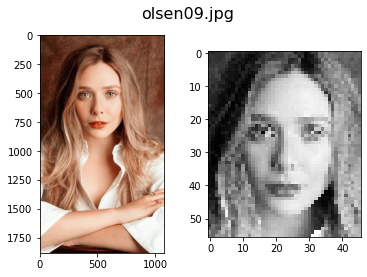

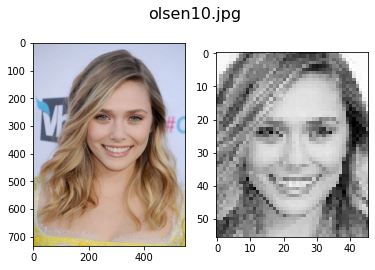

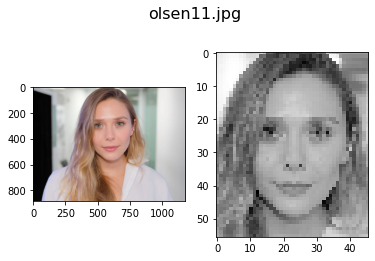

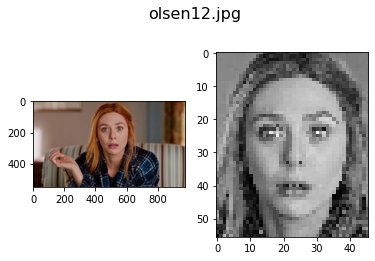

In [20]:
def normalize(
    file, expected_eye_portion=0.1, eye_scale_factor=1.2, eye_min_neighbors=3
):
    image = cv2.imread(file)
    face_aligner = Aligner(
        expected_eye_portion=expected_eye_portion,
        eye_scale_factor=eye_scale_factor,
        eye_min_neighbors=eye_min_neighbors,
    )
    image = face_aligner.alignFace(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    return image


def normalize_directory(
    directory,
    expected_eye_portion=0.1,
    eye_scale_factor=1.2,
    eye_min_neighbors=3,
    write_to_file=False,
):
    i = 0
    for file in glob(directory):
        i += 1
        image = cv2.imread(file)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(os.path.basename(file), fontsize=16)
        ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        face_aligner = Aligner(
            expected_eye_portion=expected_eye_portion,
            eye_scale_factor=eye_scale_factor,
            eye_min_neighbors=eye_min_neighbors,
        )
        image = face_aligner.alignFace(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        if image is not None:
            ax2.imshow(image, cmap="gray")
            new_file_name = os.path.join("dataset", os.path.basename(file))
            if write_to_file:
                cv2.imwrite(new_file_name, image)


def detect_faces_and_eyes(
    directory, expected_eye_portion=0.1, eye_scale_factor=1.2, eye_min_neighbors=3
):
    for file in glob(directory):
        image = cv2.imread(file)
        face_aligner = Aligner(
            expected_eye_portion=expected_eye_portion,
            eye_scale_factor=eye_scale_factor,
            eye_min_neighbors=eye_min_neighbors,
        )
        faces = face_aligner.findFaces(image)
        for face, x, y in faces:
            plt.figure()
            plt.imshow(face, cmap="gray")
            eyes = face_aligner.findEyes(face)
            for (x, y, w, h) in eyes:
                plt.figure()
                plt.imshow(face[y: y + h, x: x + w], cmap="gray")


normalize_directory("olsen/*.jpg", eye_scale_factor=1.31, eye_min_neighbors=6)


# Load the Dataset

In [21]:
x1 = []
y1 = []

files = glob("dataset/*")
for file in files:
    image = cv2.imread(file)  # Load image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Gray scale
    x1.append(np.array(image))
    y1.append(
        "".join(
            [i for i in os.path.splitext(os.path.basename(file))[
                0] if not i.isdigit()]
        )
    )

x1 = np.array(x1)
y1 = np.array(y1)
n, h, w = x1.shape

print("Images: " + str(n))
print("Width: " + str(w) + "px")
print("Height: " + str(h) + "px")


Images: 57
Width: 46px
Height: 56px


# Analyze and Prepare the Dataset:

(57, 56, 46)
Reshape...
(57, 2576)


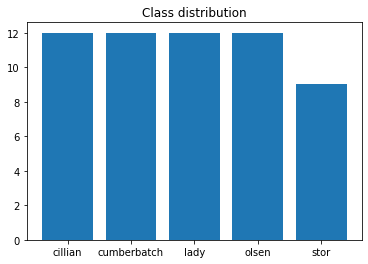

In [22]:
def count_frequency(my_list):
    """
    Returns a dictionary containing each different
    element as key, and their frequency as value.
    """
    freq = {}
    for item in my_list:
        if item in freq:
            freq[item] += 1
        else:
            freq[item] = 1
    return freq


# Plot class distribution
plt.figure()
freq = count_frequency(y1)
plt.bar(freq.keys(), freq.values())
plt.title("Class distribution")

# Shuffle train data (for better training results)
idx = rd.permutation(x1.shape[0])
x1 = x1[idx]
y1 = y1[idx]

print(x1.shape)
x1 = x1.reshape((n, w * h)) * 1.0
print("Reshape...")
print(x1.shape)


# Predict Class of New Images

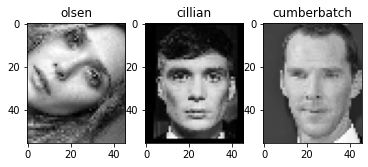

In [23]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier().fit(x1, y1)

x2 = []
x2.append(np.array(normalize("olsen.jpg", 0.16, 2.3, 3)))
x2.append(np.array(normalize("cillian.jpg")))
x2.append(np.array(normalize("cumberbatch.jpg")))

x2 = np.array(x2)
x2 = x2.reshape((x2.shape[0], w * h)) * 1.0

y2 = sgd.predict(x2)

x2 = x2.reshape((x2.shape[0], h, w))

fig, ax = plt.subplots(1, 3)

for i in range(x2.shape[0]):
    ax[i].imshow(x2[i], cmap="gray")
    ax[i].set_title(y2[i])


# [EXTRA] Another Face Detector - DNN

[INFO] Loading model...


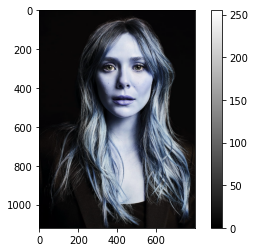

Confidence: 0.9997633


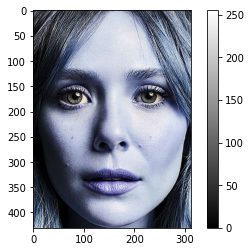

In [24]:
def plot(image, title=None):
    plt.figure()
    if title != None:
        plt.title(title)
    plt.imshow(image, cmap="gray")
    plt.colorbar()
    plt.show()


prototxt = "caffe/face/deploy.prototxt.txt"
model = "caffe/face/model.caffemodel"
min_confidence = 0.99

print("[INFO] Loading model...")
net = cv2.dnn.readNetFromCaffe(prototxt, model)

image = cv2.imread("olsen/olsen01.jpg")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plot(image)

(h, w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(
    cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0)
)

net.setInput(blob)
detections = net.forward()

for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence < min_confidence:
        continue

    print("Confidence: " + str(confidence))

    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")

    plot(image[startY:endY, startX:endX])


# Split the dataset

In [25]:
from sklearn.model_selection import train_test_split


def plot_flat(image, title=None):
    plot(image.reshape((56, 46)), title)


X_train, X_test, y_train, y_test = train_test_split(
    x1, y1, test_size=10, stratify=y1)  # Guarantee at least one class in test set

# Randomize train set
idx = rd.permutation(X_train.shape[0])
X_train = X_train[idx]
y_train = y_train[idx]

# Order test set
idx = np.argsort(y_train)
X_train = X_train[idx]
y_train = y_train[idx]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# for image in X_test:
#     plot_flat(image)


(47, 2576) (47,)
(10, 2576) (10,)


# Eigenfaces

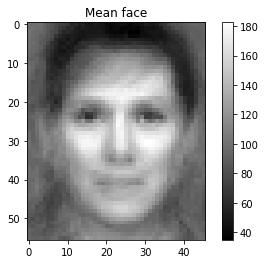

R shape (47, 47)


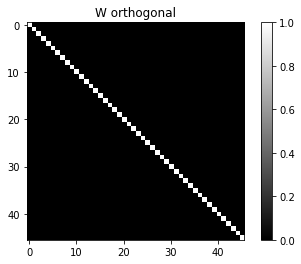

W shape (2576, 46)
Y shape (46, 47)


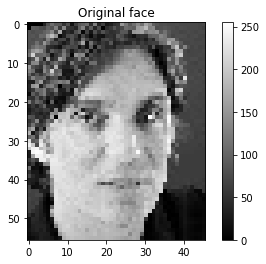

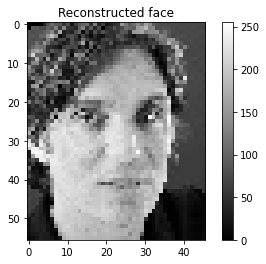

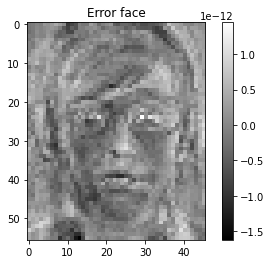

Error 2.3881703851205624e-11


In [26]:
# Get mean face
mean_face = np.zeros(56*46)
for i in X_train:
    mean_face = np.add(mean_face, i)
mean_face = np.divide(mean_face, X_train.shape[0])
plot_flat(mean_face, 'Mean face')

original_face = X_train[0].copy()

# Subtract mean face from all train faces
X_train_n = np.zeros(X_train.shape)
for i in range(X_train.shape[0]):
    X_train_n[i] = X_train[i] - mean_face

# AC components
A = X_train_n.T
R = A.T.dot(A)
w, v = np.linalg.eig(R)

print('R shape', R.shape)

# Select N-1 eigenvectors
idx = np.argsort(w)
w = w[idx]
v = v[:, idx]

w = w[1:]
v = v[:, 1:]
W = A.dot(v)

# Divide each W column by its norm
for i in range(W.shape[1]):
    W[:, i] = np.divide(W[:, i], np.linalg.norm(W[:, i]))

# W is orthogonal
plot(W.T.dot(W), 'W orthogonal')
# print(W.T.dot(W))

print('W shape', W.shape)

# Face classifier
Y = W.T.dot(A)

print('Y shape', Y.shape)

# Reconstruct
Xp = W.dot(Y)
XpT = Xp.T

# Add mean face to all reconstructed faces
Xp_n = np.zeros(XpT.shape)
for i in range(XpT.shape[0]):
    Xp_n[i] = XpT[i] + mean_face

reconstructed_face = Xp_n[0].copy()

# Compare
plot_flat(original_face, 'Original face')
plot_flat(reconstructed_face, 'Reconstructed face')

# Error face
error_face = original_face - reconstructed_face
plot_flat(error_face, 'Error face')

# Error face is orthogonal
ye = W.T.dot(error_face)
print('Error', np.sum(ye))


In [27]:
from sklearn.metrics import confusion_matrix

# Classification
test_face = X_test[0].copy()

# Subtract mean face from all test faces
X_test_n = np.zeros(X_test.shape)
for i in range(X_test.shape[0]):
    X_test_n[i] = X_test[i] - mean_face

# Projection
Z = X_test_n.T
Yz = W.T.dot(Z)

print('Yz shape', Yz.shape)

# Calculate minimum euclidean distance
guesses = len(X_test) * ['']
for i in range(Yz.shape[1]):
    distances = np.zeros(Y.shape[1])
    for j in range(Y.shape[1]):
        distances[j] = np.linalg.norm(Yz[:, i] - Y[:, j])

    minIdxDistance = np.argmin(distances)
    guesses[i] = y_train[minIdxDistance]

# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y_test, guesses))


Yz shape (46, 10)
Confusion matrix
[[1 1 0 0 0]
 [0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 0 2 0]
 [0 0 0 0 2]]
